# Train and Tune Linear Regression Model with MultioutputRegressor

In [1]:
from pathlib import Path

import numpy as np
import optuna
import optuna.visualization as vis
import pandas as pd

from src.config import Config
from src.data import time_series_split
from src.models.linreg import LinearElasticNet
from src.plots import plot_forecast_diagnostics, plot_price_overlay, plot_price_overlay_next_30
from src.preprocessing import get_preprocessor
from src.train import ModelTrainer
from src.utils import set_seed

In [2]:
cfg = Config(Path("../config/config.yaml"))
rng = set_seed(cfg.runtime.seed)
horizon = 30

2025-08-22 18:49:43,375 - INFO - src.utils - Global random seed set to 42


In [3]:
df_full = pd.read_csv(Path(cfg.data.processed_dir) / cfg.data.name_features_full)
df_full

,date,open,high,low,close,volume,adj_close,pos,neu,neg,...,sma_10,ema_10,lag_25,sma_25,ema_25,quarter,dow,q_mean,q_std,q_skew
0,2008-09-16,10905.620117,11093.219727,10742.700195,11059.019531,494760000,11059.019531,0.037859,0.649857,0.312283,...,-0.004057,-0.003995,0.004085,-0.002534,-0.002034,3,1,-0.002886,0.016242,-0.717302
1,2008-09-17,11056.580078,11057.309570,10595.900391,10609.660156,463200000,10609.660156,0.020132,0.695084,0.284784,...,-0.008344,-0.010810,-0.011943,-0.003716,-0.005068,3,2,-0.002280,0.016211,-0.771974
2,2008-09-18,10609.009766,11076.440430,10459.440430,11019.690430,488060000,11019.690430,0.076621,0.751735,0.171643,...,-0.001518,-0.001951,-0.009451,-0.001821,-0.001761,3,3,-0.003732,0.017596,-0.770069
3,2008-09-19,11027.509766,11483.049805,11026.700195,11388.440430,655110000,11388.440430,0.000513,0.772076,0.227411,...,0.001482,0.004389,0.007168,-0.000791,0.000906,3,4,-0.002244,0.018976,-0.421549
4,2008-09-22,11394.419922,11394.580078,10992.200195,11015.690430,213210000,11015.690430,0.100864,0.619301,0.279835,...,-0.004396,-0.002460,0.003778,-0.002273,-0.001724,3,0,-0.001032,0.019745,-0.341408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1958,2016-06-27,17355.210938,17355.210938,17063.080078,17140.240234,138740000,17140.240234,0.065429,0.684537,0.250034,...,-0.003397,-0.006286,0.003752,-0.000833,-0.002734,2,0,0.000002,0.009594,-0.183067
1959,2016-06-28,17190.509766,17409.720703,17190.509766,17409.720703,112190000,17409.720703,0.086932,0.714076,0.198991,...,-0.001511,-0.002307,-0.000458,-0.000191,-0.001324,2,1,-0.000028,0.009608,-0.180243
1960,2016-06-29,17456.019531,17704.509766,17456.019531,17694.679688,106380000,17694.679688,0.114712,0.673349,0.211939,...,0.000309,0.001064,0.012110,-0.000026,0.000027,2,2,0.000003,0.009624,-0.180164
1961,2016-06-30,17712.759766,17930.609375,17711.800781,17929.990234,133030000,17929.990234,0.040575,0.727080,0.232345,...,0.001104,0.003273,0.008182,0.000175,0.001041,2,3,0.000036,0.009641,-0.179361


In [4]:
train, val, test, forecast = time_series_split(df_full, train_ratio=0.8, val_ratio=0.1, horizon=horizon)

In [5]:
drop_cols = ["open", "high", "low", "close", "volume", "adj_close"]
target_cols = [c for c in df_full.columns if c == "target" or c.startswith("target_")]
feature_cols = [c for c in df_full.columns if c not in target_cols + ["date"] + drop_cols]

X_train, y_train = train[feature_cols], train[target_cols]
X_val, y_val = val[feature_cols], val[target_cols]
X_test, y_test = test[feature_cols], test[target_cols]
X_forecast = forecast[feature_cols]

In [6]:
X_test.to_parquet(Path(cfg.data.processed_dir) / "X_test_30.parquet", index=False)

In [7]:
preprocessor, _ = get_preprocessor(X_train)

In [8]:
model = LinearElasticNet(
    horizon=horizon,
    multioutput=True,
    random_state=cfg.runtime.seed,
    max_iter=2000
)

trainer = ModelTrainer(
    model=model,
    name="enet_mo_30",
    config={
        "optimization_metric": "rmse",
        "gap": 0,
        "seed": cfg.runtime.seed
    },
    preprocessor=preprocessor,
    y_scale=True
)

2025-08-22 18:49:43,778 - INFO - ModelTrainer - Initialized ModelTrainer for model: enet_mo_30


In [9]:
study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(seed=cfg.runtime.seed),
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=2)
)

study.optimize(lambda trial: trainer.objective(trial, X_train, y_train), n_trials=30)

best_params = study.best_trial.user_attrs["best_params"]

pd.Series(best_params).to_csv(Path(cfg.data.processed_dir) / cfg.model.best_params_enet_mo_best_30)
print("Best params:", best_params)

[I 2025-08-22 18:49:43,860] A new study created in memory with name: no-name-79855492-5dca-4268-ac87-1dd5e19b07d5
D:\IntelliJ\ml-stock-sent\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.141e+01, tolerance: 3.880e-02
  model = cd_fast.enet_coordinate_descent(
D:\IntelliJ\ml-stock-sent\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.414e-01, tolerance: 3.880e-02
  model = cd_fast.enet_coordinate_descent(
D:\IntelliJ\ml-stock-sent\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to inc

Best params: {'alpha': 0.009311403260660715, 'l1_ratio': 0.8397646127079323, 'selection': 'random', 'max_iter': 5000, 'random_state': 42}


In [10]:
best_model = model.__class__(**{**model.get_params(), **best_params})

final_trainer = ModelTrainer(
    model=best_model,
    name="enet_mo_30",
    config={
        "optimization_metric": "rmse",
        "gap": 0,
        "seed": cfg.runtime.seed,
    },
    preprocessor=preprocessor,
    y_scale=True,
)

trainer.fit(X_train, y_train)
# trainer.fit(X_train, y_train, X_val, y_val)

2025-08-22 18:49:57,532 - INFO - ModelTrainer - Initialized ModelTrainer for model: enet_mo_30
2025-08-22 18:49:57,532 - INFO - ModelTrainer - Starting model training...
D:\IntelliJ\ml-stock-sent\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.242e-01, tolerance: 1.546e-01
  model = cd_fast.enet_coordinate_descent(
D:\IntelliJ\ml-stock-sent\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.203e-01, tolerance: 1.546e-01
  model = cd_fast.enet_coordinate_descent(
D:\IntelliJ\ml-stock-sent\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWa

In [11]:
results = {
    "train": trainer.evaluate(X_train, y_train),
    "val": trainer.evaluate(X_val, y_val),
    "test": trainer.evaluate(X_test, y_test)
}

meta = {
    "model": "enet_mo_30",
    "with_sentiment": True,
    "horizon": horizon
}

flat_rows = []
for split, metrics in results.items():
    row = {"split": split, **meta, **metrics}
    flat_rows.append(row)

results_df = pd.DataFrame(flat_rows)

results_df.to_csv(Path(cfg.data.processed_dir) / cfg.data.results_direct_multi_step, index=False)
results_df

2025-08-22 18:49:57,933 - INFO - ModelTrainer - Evaluating model...
2025-08-22 18:49:57,939 - INFO - ModelTrainer - Evaluating model...
2025-08-22 18:49:57,944 - INFO - ModelTrainer - Evaluating model...


,split,model,with_sentiment,horizon,mae,mse,rmse,smape,r2
0,train,enet_mo_30,True,30,0.008057,0.000156,0.012483,1.560783,0.034152
1,val,enet_mo_30,True,30,0.006952,0.000090,0.009488,1.601506,-0.060672
2,test,enet_mo_30,True,30,0.007771,0.000103,0.010127,1.592334,-0.050532


In [12]:
model_path = trainer.save()

In [13]:
vis.plot_optimization_history(study).show()
vis.plot_param_importances(study).show()
vis.plot_slice(study).show()
vis.plot_parallel_coordinate(study).show()
vis.plot_contour(study).show()
vis.plot_edf(study).show()

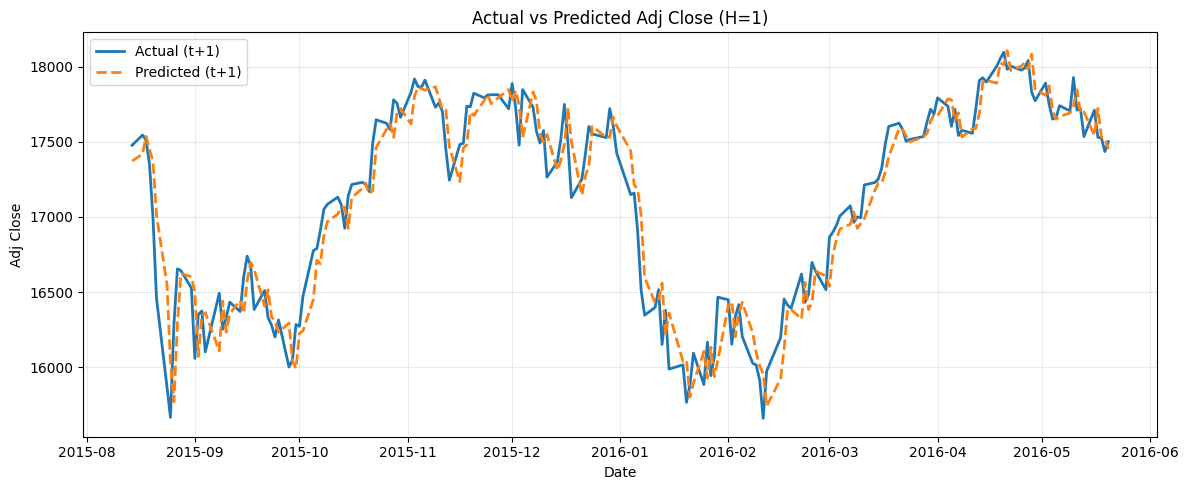

In [14]:
y_pred = trainer.predict(X_test)
plot_price_overlay(df_full, X_test, y_pred, Path(cfg.data.fig_dir) / "pred_vs_actual_adj_close_price_plus_1.png")

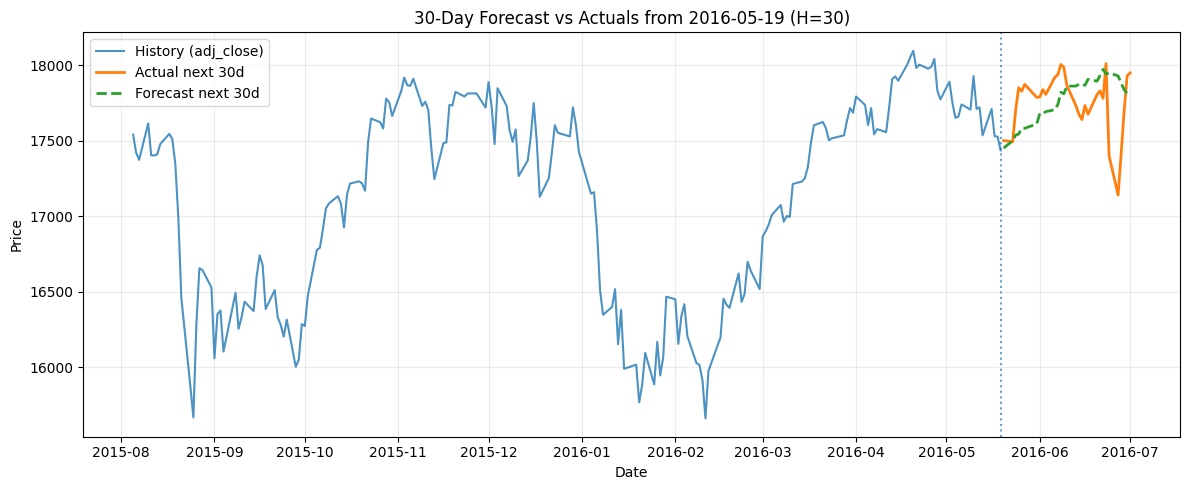

In [15]:
plot_price_overlay_next_30(df_full, test, y_pred, horizon=horizon, hist_window=200, path=Path(cfg.data.fig_dir) / "pred_vs_actual_adj_close_price_plus_30.png")

In [16]:
y_true = np.asarray(y_test)

anchor_idx = int(X_test.index[-1])
last_price = df_full.loc[anchor_idx, "adj_close"]

future_rows = df_full.iloc[anchor_idx + 1: anchor_idx + 1 + horizon]
future_dates = pd.to_datetime(future_rows["date"].to_numpy())

actual_price_path = last_price * np.exp(np.cumsum(y_true[-1]))
pred_price_path = last_price * np.exp(np.cumsum(y_pred[-1]))

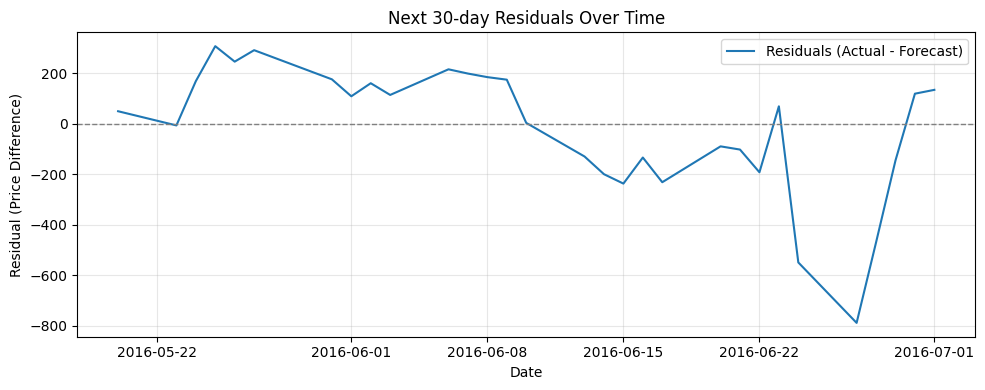

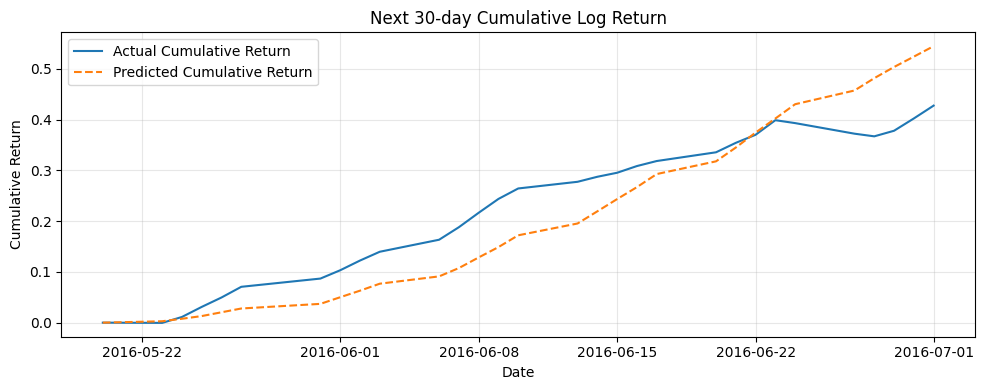

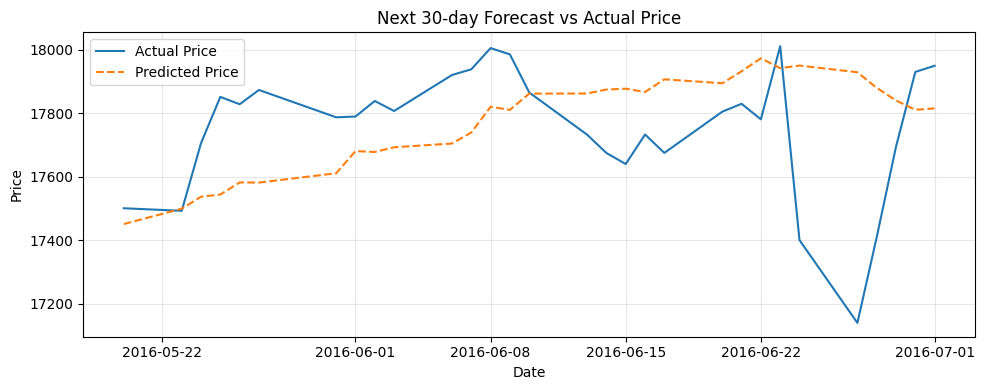

In [17]:
plot_forecast_diagnostics(
    future_dates=future_dates,
    actual_price_path=actual_price_path,
    pred_price_path=pred_price_path,
    path=Path(cfg.data.fig_dir) / "forecast_eval_plus_30.png"
)